In [1]:
import imaging_behavior_functions
import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary
from scipy.stats import sem
import random
import json
from scipy.integrate import quad

In [2]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/hDeltaB_imaging/qualified_sessions/no_odor/"
example_path_data = base_path+"20230518-7_hDeltaB_EPG_syntGCAMP7f_fly2_long_nojump_15/data/"
example_path_results = base_path+"20230518-7_hDeltaB_EPG_syntGCAMP7f_fly2_long_nojump_15/results/"
trial_num = 2
odor_threshold = 5
time_interval_threshold = 16  # Assuming time is in seconds or an equivalent unit
k = 8
window_size = 30

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
#behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
combined_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
#smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

### EPG processing 

In [3]:
epg_df = neural_df.filter(like='EPG')
epg_df

,EPG_0,EPG_1,EPG_2,EPG_3,EPG_4,EPG_5,EPG_6,EPG_7,EPG_8,EPG_9,...,EPG_20,EPG_21,EPG_22,EPG_23,EPG_24,EPG_25,EPG_26,EPG_27,EPG_28,EPG_29
0,4.147839,1.438727,0.990043,0.879386,0.434233,0.374064,0.304000,0.459419,0.277433,0.135183,...,0.400574,0.605627,0.375781,0.415475,-0.120020,0.320703,0.509343,1.464053,2.680541,4.558435
1,4.979036,2.079402,1.489523,1.525421,1.104053,0.557512,0.551224,0.570018,0.342264,0.174353,...,0.624170,0.721638,0.374454,0.451477,0.003281,0.471016,0.468525,1.700727,3.014833,5.518810
2,6.121290,2.694362,2.126830,2.381486,1.896828,0.729266,0.770590,0.630143,0.317476,0.211867,...,0.972194,0.773322,0.372556,0.445436,0.040831,0.476558,0.499780,1.688906,3.092060,5.829029
3,6.427674,2.952535,2.434662,2.830171,2.182438,0.788391,0.769984,0.560222,0.261592,0.221937,...,1.257329,0.850224,0.452131,0.443253,0.014158,0.387471,0.490458,1.520665,2.463217,4.590824
4,6.601193,2.990041,2.408201,2.830172,2.021195,0.770916,0.684510,0.487590,0.303205,0.203301,...,1.295309,1.056681,0.524761,0.497530,0.011867,0.336724,0.446718,1.289418,1.721795,2.768832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,2.133240,0.735467,0.678741,0.334804,0.346937,0.302911,0.507436,2.001921,1.732200,3.245923,...,0.676469,0.797975,3.004048,3.100393,4.567490,3.976748,2.288552,2.271341,3.229744,8.371187
1435,1.800140,0.744066,0.639584,0.293968,0.286376,0.226504,0.427709,1.494255,1.473770,2.945574,...,0.544528,0.786769,2.724023,2.783935,4.246709,4.045285,2.284706,2.406020,2.896136,8.897570
1436,1.636939,0.739794,0.645039,0.229436,0.213979,0.250012,0.397160,1.084271,1.317430,2.649954,...,0.499411,0.841107,2.347730,2.471919,3.768936,3.921461,2.214371,2.433910,2.852013,8.393478
1437,1.777719,0.733790,0.699858,0.147726,0.201703,0.302637,0.449117,0.973038,1.258229,2.559987,...,0.519497,0.851616,2.035237,2.363113,3.461410,3.872266,2.044998,2.587573,3.269795,5.750211


In [7]:
pva_phase, pva_amplitude = imaging_behavior_functions.calculate_pva(np.transpose(roi_mtx))

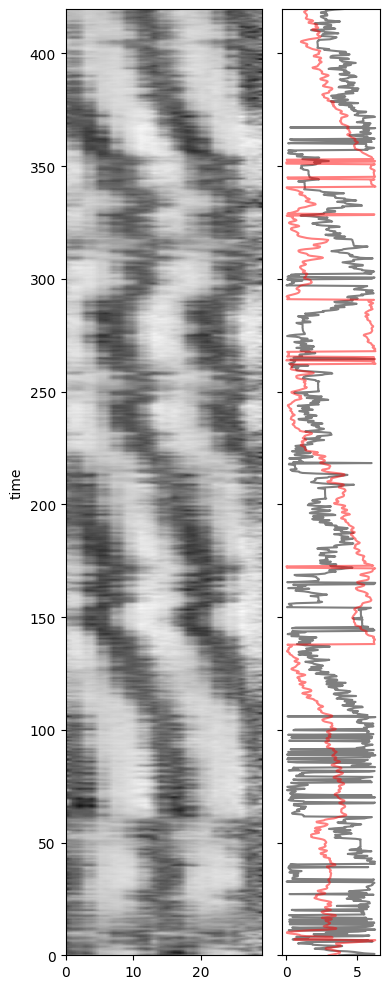

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [2, 1]})
ind1 = 0
ind2 = len(epg_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
ax2.plot(2*np.pi-behav_df.heading, behav_df.time, color='black',alpha=0.5,label='heading')
ax2.plot(pva_phase+np.pi, behav_df.time, color='red',alpha=0.5,label='PVA estimate')
#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()



Text(0, 0.5, 'heading')

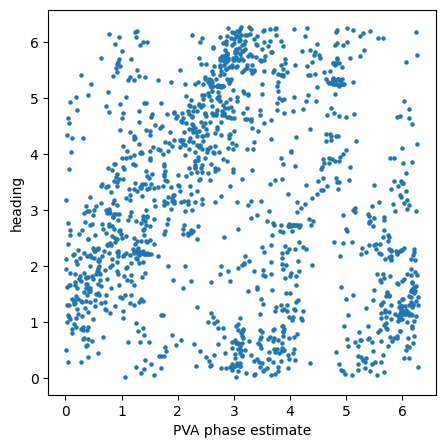

In [24]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(pva_phase+np.pi, 2*np.pi-behav_df.heading, marker = 'o',s=5)
ax.set_xlabel('PVA phase estimate')
ax.set_ylabel('heading')

In [30]:
def calculate_translational_velocity_df(df):
    """
    Calculate translational velocities and directions for multiple time points provided in a DataFrame.

    Parameters:
        df (pandas.DataFrame): DataFrame containing columns 'fwV' for forward velocity (mm/s) 
                               and 'sideV' for side velocity (rad/s).
        radius (float): Radius of the ball in mm.
        heading_direction_rad (float): Instantaneous heading direction of the animal in radians (assumed constant for simplicity).

    Returns:
        pandas.DataFrame: DataFrame with additional columns 'translational_velocity_mm_s' and 'translational_direction_rad'.
    """
    # Convert side velocity from rad/s to mm/s
    #df['side_velocity_mm'] = df['sideV'] * radius

    # Calculate components of the translational velocity
    df['forward_component'] = df['fwV'] * np.cos(df['heading']) - df['sideV'] * np.sin(df['heading'])
    df['side_component'] = df['fwV'] * np.sin(df['heading']) + df['sideV'] * np.cos(df['heading'])

    # Calculate the magnitude of the translational velocity
    df['translational_velocity_mm_s'] = np.sqrt(df['forward_component']**2 + df['side_component']**2)

    # Calculate the direction of the translational velocity
    df['translational_direction_rad'] = np.arctan2(df['side_component'], df['forward_component'])

    # Optional: drop intermediate columns if they are not needed
    df.drop(columns=['forward_component', 'side_component'], inplace=True)

    return df

radius = 4.5 
result_df = calculate_translational_velocity_df(behav_df)
result_df

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,odor,xPos,yPos,translational_velocity_mm_s,translational_direction_rad
0,0.000000,0.000000,0.000000,0.000000,2.540664,0.000000,0.000000,0.000000,0,2.540664,0,0.000000,0.000000,0.000000,3.141593
1,0.291870,0.696185,-32.928144,-30.708904,1.454190,32.928144,30.708904,64.333233,1,1.454190,0,0.044016,-0.626263,32.935502,-0.095467
2,0.583740,8.499344,12.815933,-2.123687,0.074177,12.815933,2.123687,23.438963,1,0.074177,0,-1.798376,-2.595139,15.378133,1.059385
3,0.875611,1.134228,-9.594566,6.919436,0.804745,9.594566,6.919436,17.648230,1,0.804745,0,-1.945951,-2.777397,9.661375,-0.648382
4,1.167481,-0.824603,0.658063,1.458741,1.148195,0.658063,1.458741,2.941406,1,1.148195,0,-1.717696,-2.807699,1.054996,-2.666940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,418.541933,15.521392,1.519229,-4.780070,3.477513,1.519229,4.780070,21.820690,1,9.760698,0,-16.672443,-58.184870,15.595565,-2.708103
1435,418.833803,14.647178,-2.103455,2.773887,3.502246,2.103455,2.773887,19.524521,1,9.785432,0,-13.213934,-55.730121,14.797444,-2.923572
1436,419.125673,11.800752,-4.680957,-8.860673,3.285416,4.680957,8.860673,25.342381,1,9.568601,0,-10.986648,-53.202046,12.695239,2.907787
1437,419.417544,15.862324,-11.465036,-7.829767,2.886886,11.465036,7.829767,35.157128,1,9.170071,0,-9.653440,-48.958776,19.571929,2.261032


In [37]:
min(result_df.translational_direction_rad)

-3.139369846163373

In [31]:
hdeltab_df = neural_df.filter(like='hDeltaB')
hdeltab_df

,hDeltaB_0,hDeltaB_1,hDeltaB_2,hDeltaB_3,hDeltaB_4,hDeltaB_5,hDeltaB_6,hDeltaB_7,hDeltaB_8,hDeltaB_9,hDeltaB_10,hDeltaB_11,hDeltaB_12,hDeltaB_13,hDeltaB_14,hDeltaB_15,hDeltaB_16
0,1.443987,1.236244,1.212282,0.774679,0.908377,0.783001,0.617507,0.375313,0.578255,0.682197,1.189474,1.363177,1.500883,1.337283,1.513321,1.536944,1.705236
1,1.807226,1.512185,1.306097,0.902912,1.063353,0.896722,0.770106,0.482497,0.586361,0.694678,1.094572,1.278074,1.353177,1.365979,1.463160,1.532325,1.760992
2,2.332164,1.896181,1.387390,1.078990,1.253558,0.938083,0.858950,0.528520,0.550452,0.659167,0.925116,1.135079,1.278694,1.399738,1.443692,1.583514,1.995499
3,2.637748,2.181846,1.415740,1.205810,1.376996,0.901945,0.880086,0.525245,0.513407,0.590941,0.767496,1.004639,1.307294,1.417431,1.470623,1.639194,2.216604
4,2.469291,2.235252,1.461721,1.223292,1.387901,0.878157,0.863469,0.507010,0.441452,0.520518,0.657957,0.940920,1.337082,1.431791,1.441660,1.634586,2.228343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,0.325329,0.125195,0.046030,0.012482,-0.012659,-0.033616,0.070846,0.153661,0.508768,0.819196,1.118824,1.031128,1.165446,1.186265,1.215623,1.423523,1.710405
1435,0.251155,0.165444,0.065495,0.019386,-0.011835,-0.010142,0.056557,0.137837,0.540238,0.752023,1.122005,1.095642,1.140701,1.166995,1.190348,1.420262,1.841219
1436,0.207071,0.216133,0.128904,0.034807,0.014957,-0.008088,0.059813,0.116087,0.490214,0.684914,1.087284,1.081490,1.107204,1.151288,1.169719,1.356024,1.913976
1437,0.218149,0.265304,0.141574,0.039301,0.019163,-0.054425,0.047989,0.164945,0.434842,0.652636,1.117728,1.048777,1.068820,1.183930,1.189981,1.322363,1.865213


<Axes: >

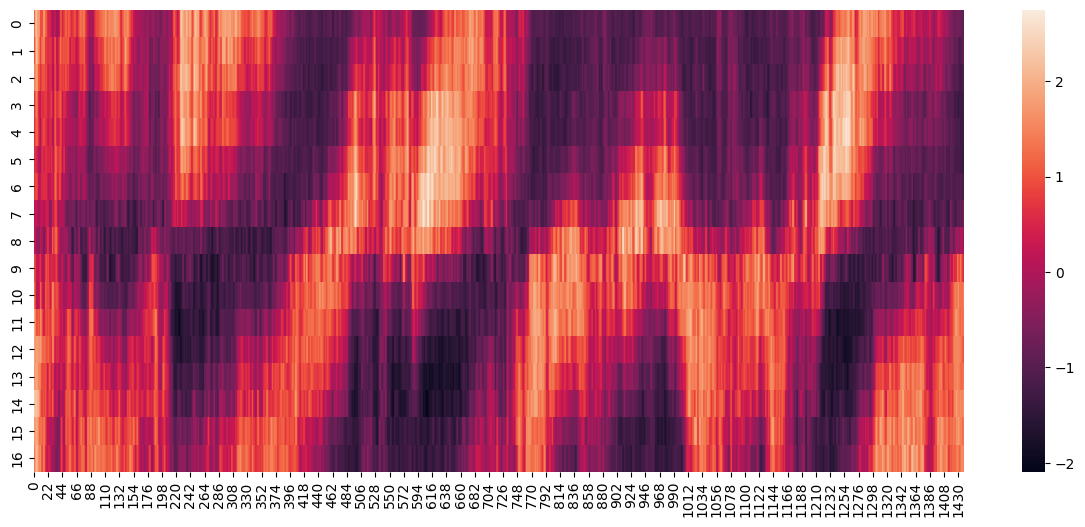

In [32]:
scaler = StandardScaler()
roi_mtx_ori =  hdeltab_df
roi_mtx = scaler.fit_transform(roi_mtx_ori)
plt.figure(figsize=(15, 6))
sns.heatmap(np.transpose(roi_mtx))

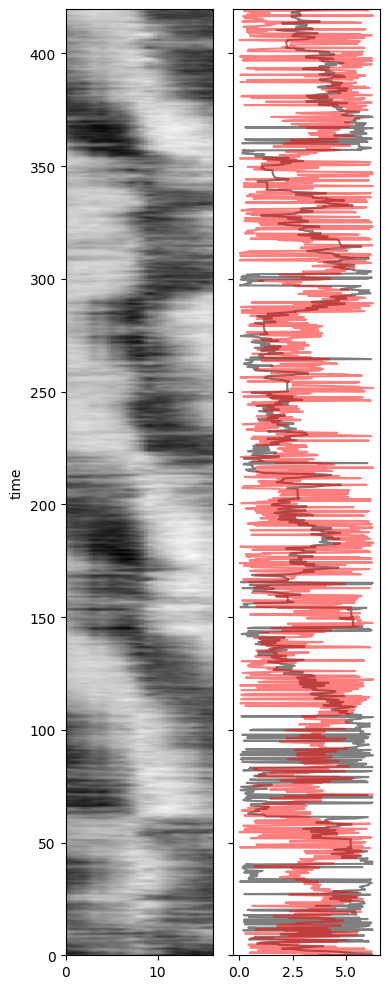

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [1, 1]})
ind1 = 0
ind2 = len(hdeltab_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
ax2.plot(2*np.pi-behav_df.heading, behav_df.time, color='black',alpha=0.5,label='heading')
ax2.plot(result_df.translational_direction_rad+np.pi, behav_df.time, color='red',alpha=0.5,label='translational direction')
#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()

In [30]:
roi_kw = 'FR1'
roi_kw2 = 'CRE'
combined_df_trun, nonpara_summ_df = imaging_behavior_functions.calc_nonpara(combined_df,roi_kw,roi_kw2)

In [31]:
nonpara_summ_df

,Mean,IQR,translationalV,fwV
1,1.103497,1.451094,7.290209,5.119072
2,1.025990,1.366783,7.174576,5.211408
3,0.966939,1.283895,6.978295,5.387884
4,0.969969,1.081592,6.761358,5.633186
5,0.940891,1.095915,6.598824,5.928506
...,...,...,...,...
2492,0.528849,0.532048,4.984886,4.971437
2493,0.529808,0.537546,5.409618,5.333589
2494,0.495787,0.540766,5.792884,5.631789
2495,0.465849,0.500712,6.081127,5.843077


<Axes: >

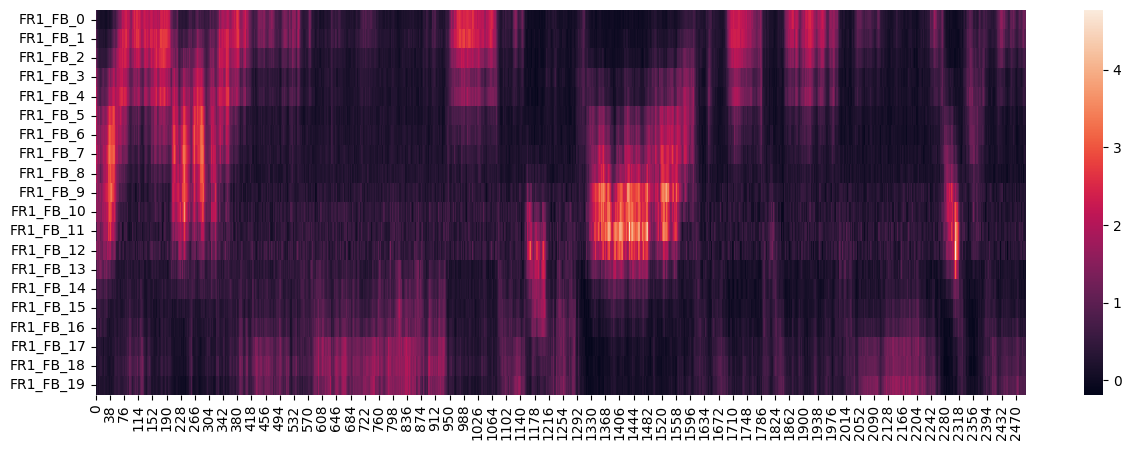

In [7]:
fig, axes = plt.subplots(figsize=(15,5))
sns.heatmap(np.transpose(neural_df.iloc[:,3:23]))

<Axes: >

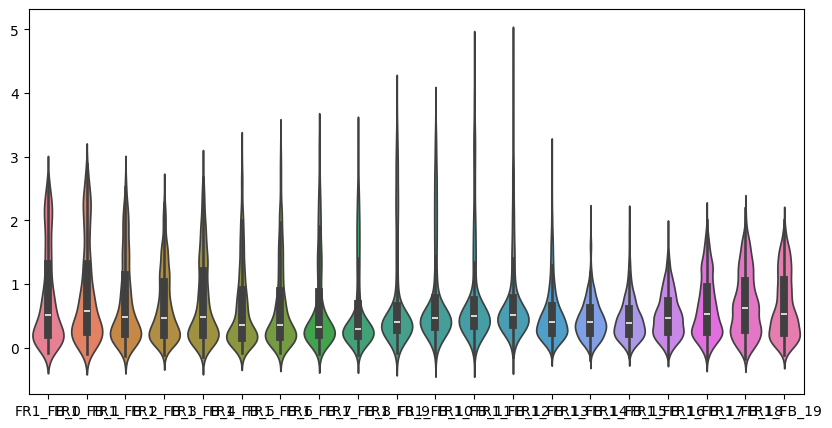

In [8]:
fig, axes = plt.subplots(figsize=(10,5))
sns.violinplot(data = neural_df.iloc[:,3:23])

<Axes: >

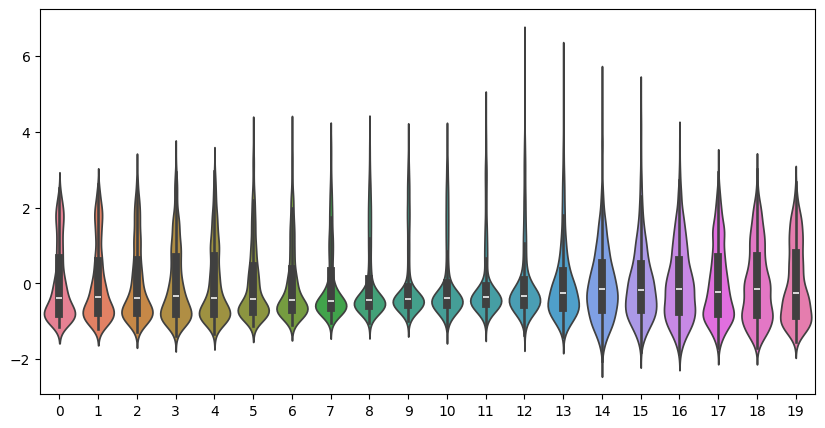

In [9]:
scaler = StandardScaler()
df_fl_tr = scaler.fit_transform(neural_df.iloc[:,3:23])
fig, axes = plt.subplots(figsize=(10,5))
sns.violinplot(data = df_fl_tr)

<Axes: >

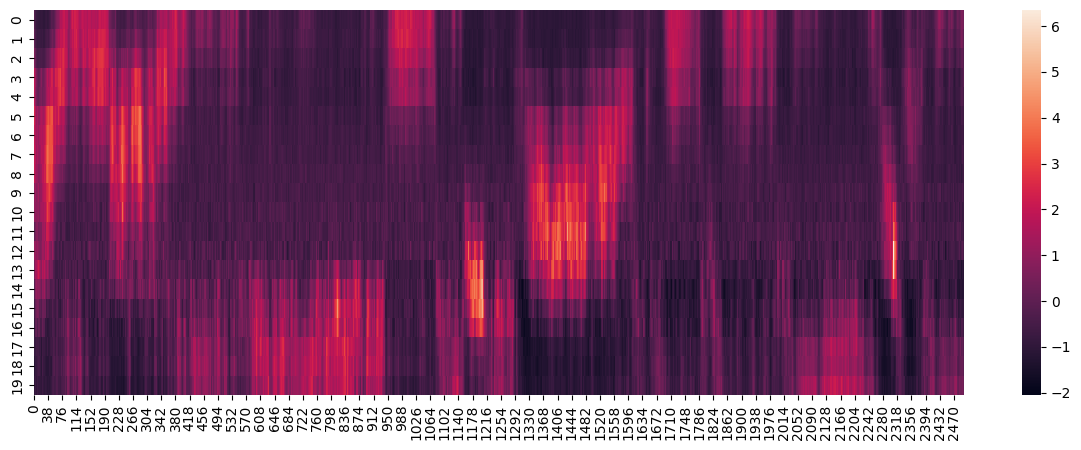

In [10]:
fig,ax = plt.subplots(figsize=(15,5))
sns.heatmap(np.transpose(df_fl_tr))

,time,phase,baseline,amplitude,phase_error,baseline_error,amplitude_error
0,0.000000,2.314858,0.796835,1.790906,0.085377,0.109136,0.155766
1,0.240313,2.314858,0.753135,1.672041,0.097086,0.115805,0.165201
2,0.480626,2.314858,0.637563,1.516739,0.105184,0.113716,0.162089
3,0.720939,2.314858,0.574750,1.294124,0.113303,0.103891,0.147220
4,0.961252,2.645552,0.639188,1.061398,0.135224,0.100166,0.139761
...,...,...,...,...,...,...,...
2492,598.859955,0.330694,-0.357345,0.523188,0.234831,0.085156,0.117945
2493,599.100268,0.330694,-0.350886,0.492460,0.244763,0.083667,0.116067
2494,599.340581,0.330694,-0.408382,0.503896,0.222833,0.078265,0.109058
2495,599.580894,0.330694,-0.456045,0.491203,0.198769,0.068092,0.094939


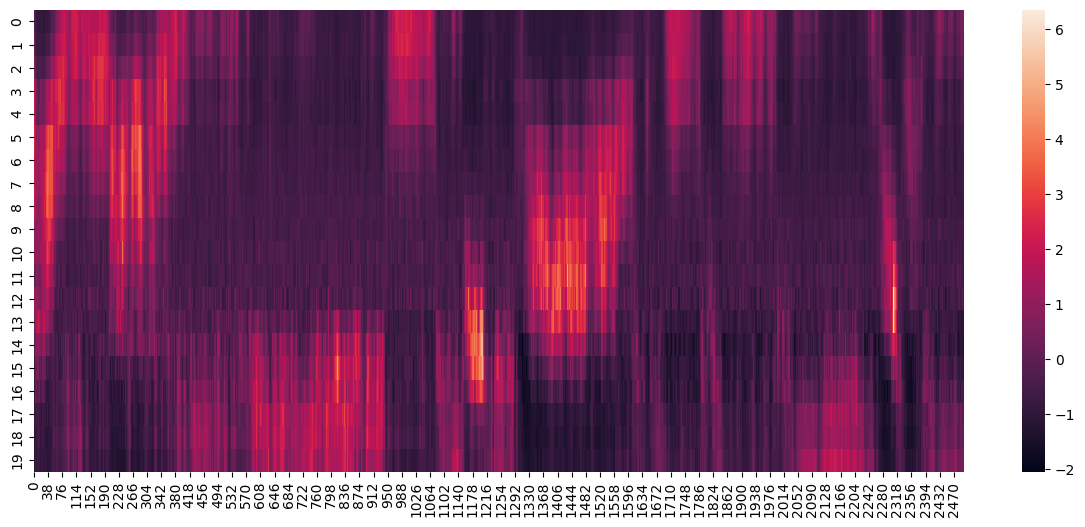

In [11]:
scaler = StandardScaler()
roi_mtx = scaler.fit_transform(neural_df.iloc[:,3:23])
plt.figure(figsize=(15, 6))
sns.heatmap(np.transpose(roi_mtx))
param_df = imaging_behavior_functions.fit_sinusoid(neural_df,roi_mtx)
param_df

In [35]:
iqr(roi_mtx,interpolation='midpoint',axis=1)

array([2.58468765, 2.51435359, 2.35152232, ..., 0.72611511, 0.62854761,
       0.55600997])

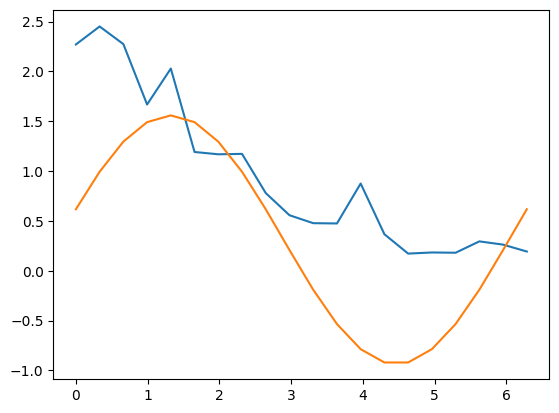

In [29]:
idx = 150
x_p = np.linspace(0,2*np.pi,20)
plt.plot(x_p,neural_df.iloc[idx,3:23])
dist = param_df.baseline[idx]
amp = param_df.amplitude[idx]
phi = param_df.phase[idx]
plt.plot(x_p, dist + amp * np.cos(x_p - phi))

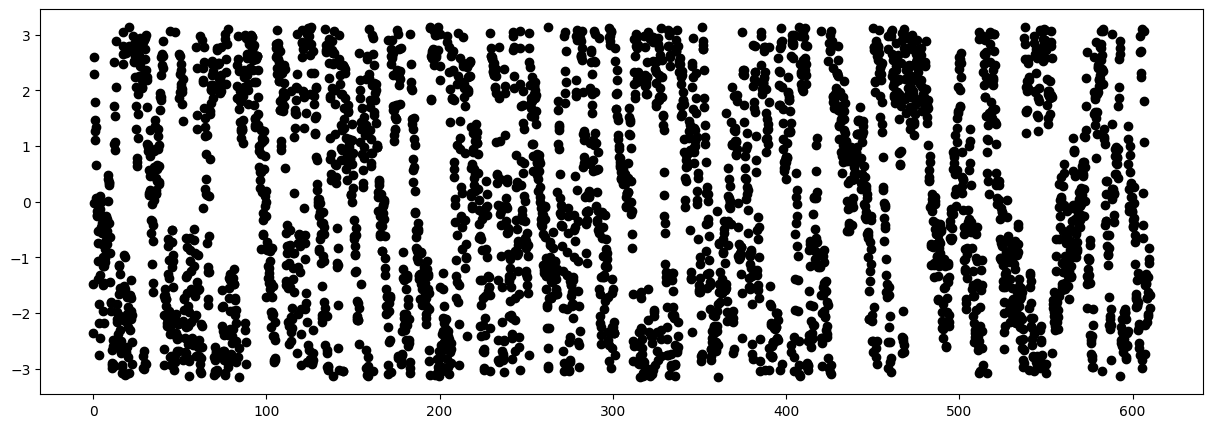

In [ ]:
# bump phase vs heading difference
fig, ax = plt.subplots(figsize=[15,5])
ind1 = 0
ind2 = len(fl_df)
#ax.scatter(fl_df.time[ind1:ind2], np.unwrap(fl_df.heading[ind1:ind2]),color='blue', alpha = 0.5)
#ax.plot(fl_df.time,phase, color = 'red') # find the phase with the highest activity
#ax.plot(fl_df.time[ind1:ind2],np.unwrap(phase_sinfit[ind1:ind2]), color = 'orange')
phase_dif = np.angle(np.exp(1j*fl_df.heading[ind1:ind2])/np.exp(1j*(phase_sinfit[ind1:ind2]))) 
ax.scatter(fl_df.time[ind1:ind2],phase_dif, color = 'black')
#np.angle(np.exp(1i*x)./np.exp(1i*y))

Text(0, 0.5, 'forward velocity (mm/s)')

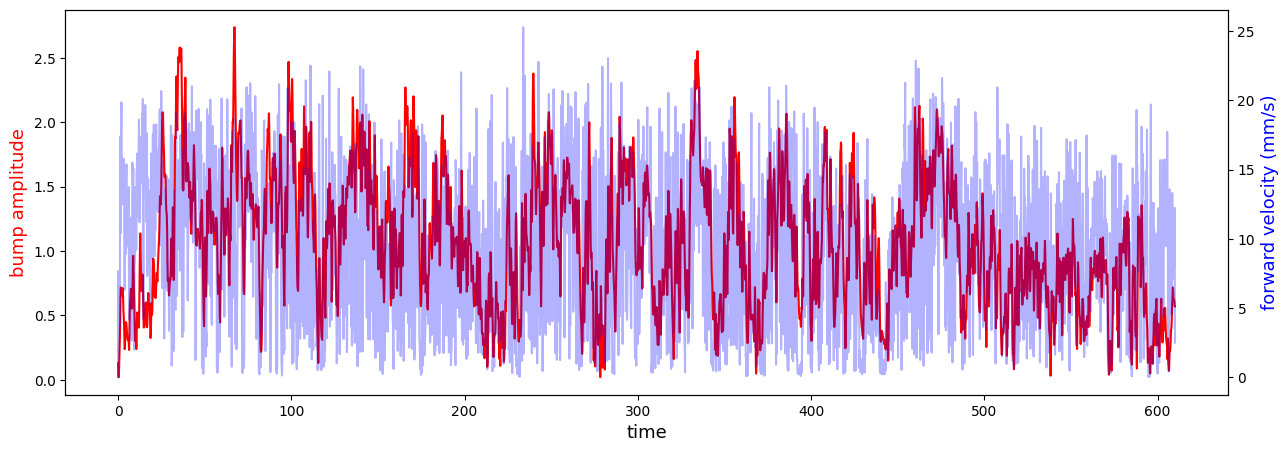

In [ ]:
fig, ax = plt.subplots(figsize=[15,5])
ind1 = 0
ind2 = len(fl_df)
#heading_df = np.diff(np.squeeze(heading_tf))
ax.plot(fl_df.time[ind1:ind2], amp_sinfit[ind1:ind2],color = 'red')
#ax.plot(fl_df.time[ind1:ind2], fl_df.hDeltaB1[ind1:ind2],color='red')
#ax.plot(fl_df.time[ind1:ind2], fl_df.hDeltaB3[ind1:ind2],color='orange')
#ax.plot(fl_df.time[ind1:ind2], fl_df.MBON30R[ind1:ind2],color='orange')
ax2 = ax.twinx()
#ax.plot(fl_df.time[ind1:ind2], PAM12_soma1_tf[ind1:ind2],color='orange')
#ax.plot(fl_df.time[ind1:ind2], PAM12_soma2_tf[ind1:ind2],color='salmon')
#ax.plot(fl_df.time[ind1:ind2], PAM12_soma3_tf[ind1:ind2],color='gold')
#ax2 = ax1.twinx()
#ax.plot(fl_df.time[ind1:ind2], yawV_tf[ind1:ind2],color='gold')
#ax.plot(fl_df.time[ind1:ind2], sideV_tf[ind1:ind2],color='orange')
#ax.plot(fl_df.time[ind1:ind2], heading_tf[ind1:ind2],color='salmon')
ax2.plot(fl_df.time[ind1:ind2], fl_df.net_motion[ind1:ind2],color='blue',alpha = 0.3)
#ax2.plot(fl_df.time[ind1:ind2], phase_dif, color = 'blue')
#ax2.scatter(fl_df.time[ind1:ind2], fl_df.heading_adj2[ind1:ind2],color='black',alpha = 0.3)
ax.set_xlabel('time', fontsize = 13)
ax.set_ylabel('bump amplitude', fontsize = 13, color = 'red')
#ax2.set_ylabel('heading adj (mm/s)', fontsize = 13, color = 'blue')
ax2.set_ylabel('forward velocity (mm/s)', fontsize = 13, color = 'blue')
#fig.legend(loc = 'upper center',fontsize = 13)
# locomotion is the main driver of PAM12 activities: no obvious tuning towards looming
# possibilities: 1. looming is not the right aversive stimuli; 2. need to be in a meaningful behavioral condition, e.g. with 
# odor? 
# band-pass: filter out some low frequency components 
# total locomotion: add ball movement in all directions 
# time since onset of running 

In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

Text(0, 0.5, 'fw velocity (mm/s)')

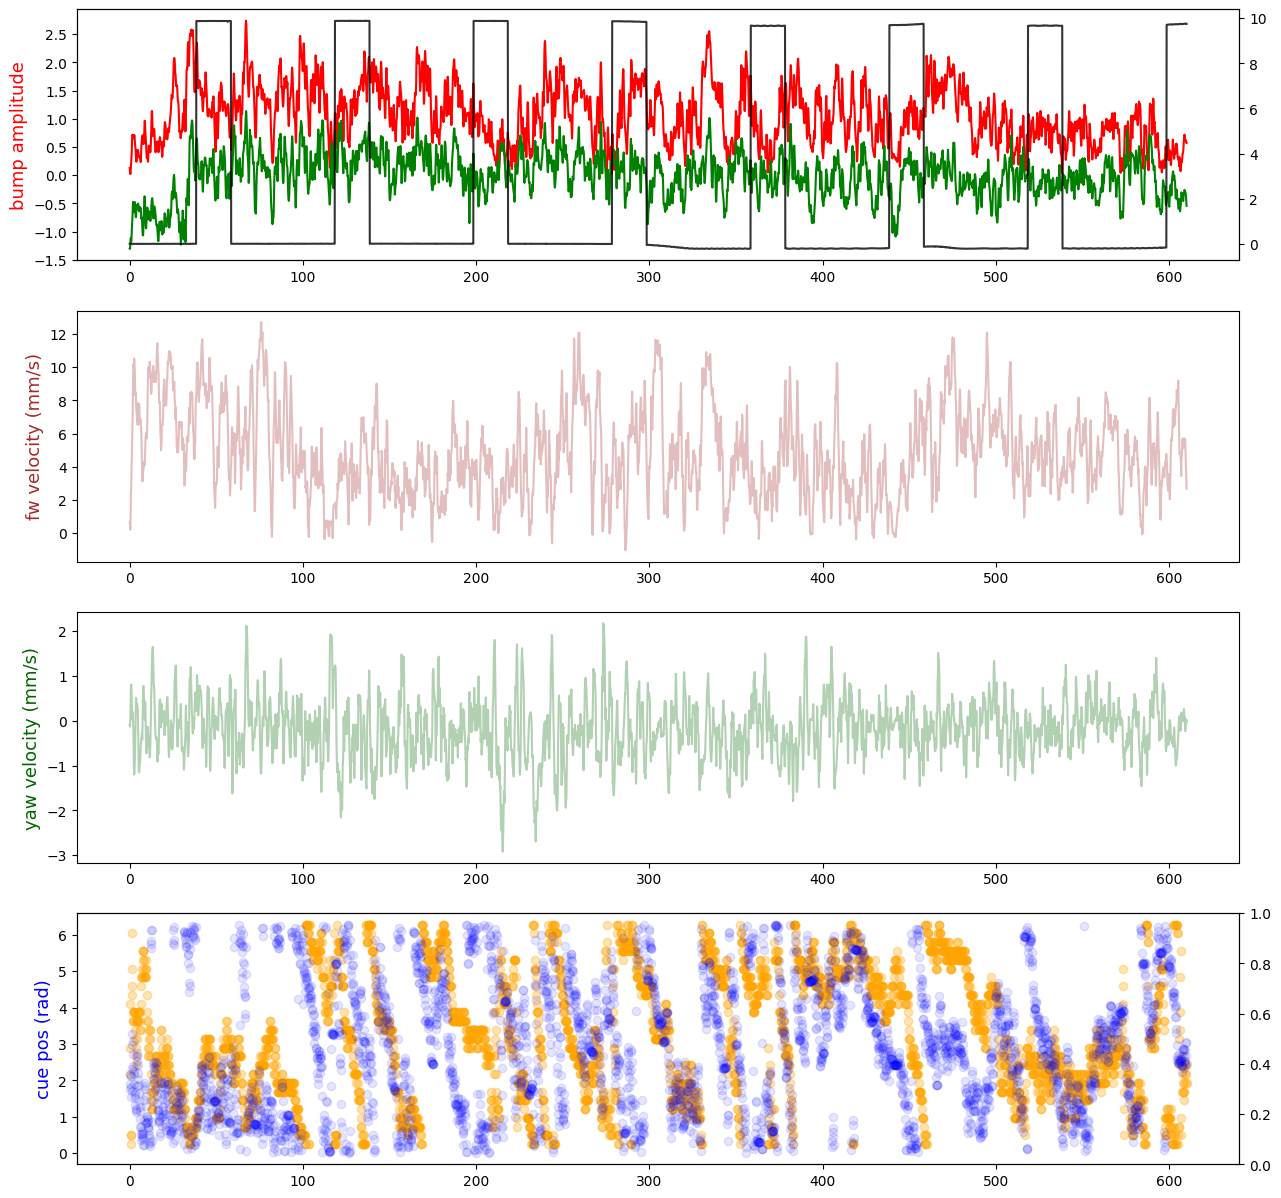

In [ ]:
fig_ex, ax = plt.subplots(4,1,figsize=[15,15])
ind1 = 0
ind2 = len(fl_df) 
ax[0].plot(fl_df.time[ind1:ind2], amp_sinfit[ind1:ind2],color = 'red')
ax[0].plot(fl_df.time[ind1:ind2], base_sinfit[ind1:ind2],color = 'green')
ax[0].set_ylabel('bump amplitude', fontsize = 13, color = 'red')
ax4 = ax[0].twinx()
ax4.plot(fl_df.time[ind1:ind2], fl_df.odor[ind1:ind2],color='black',alpha = 0.8)
#ax2 = ax[0].twinx()
#ax2.plot(fl_df.time[ind1:ind2], fl_df.mean_MBON09[ind1:ind2],color='darkgreen', alpha = 0.5)
#ax2.set_ylabel('MBON09 df/f', fontsize = 13, color = 'darkgreen')
#ax[1].plot(fl_df.time[ind1:ind2], fl_df.odor[ind1:ind2],color='brown',alpha = 0.8)
#ax[1].set_ylabel('odor delivery', fontsize = 13, color = 'brown')
#ax[3].scatter(fl_df.time[ind1:ind2], fl_df.heading[ind1:ind2],color='blue',alpha = 0.3)
ax[3].scatter(fl_df.time[ind1:ind2],2*np.pi-phase_sinfit[ind1:ind2], color = 'orange',alpha = 0.3)
ax[3].scatter(fl_df.time[ind1:ind2], fl_df.heading[ind1:ind2],color ='blue',alpha = 0.1)
#ax[3].scatter(fl_df.time[ind1:ind2], heading_intp[ind1:ind2],color ='orange',alpha = 0.3)
#ax[3].scatter(jumpbar_pd.time[:-600], 2*np.pi-jumpbar_pd.panel_heading[600:],color ='orange',alpha = 0.1)
#for i in range(len(jump_idx[0])):
   # ax[3].axvline(jumpbar_pd.time[jump_idx[0][i]],color ='red')
#ax[3].scatter(fl_df.time[ind1:ind2], 2*np.pi-heading_interp,color ='green',alpha = 0.3)
#ax[3].axvline(x = fl_df.time[int(np.ceil(bar_jump_scaled))],color = 'black')
#ax[3].axvline(x = fl_df.time[int(np.floor(bar_jump_scaled))],color = 'black')
ax[3].set_ylabel('cue pos (rad)', fontsize = 13, color = 'blue')
ax2 = ax[3].twinx()
#ax2.set_ylabel('hDeltaB bump phase (rad)', fontsize = 13, color = 'orange')
#ax[3].axvline(jumpbar_df.iloc[6198,1]-jumpbar_df.iloc[815,1],color = 'black')
#ax[3].axvline(jumpbar_df.iloc[12398,1]-jumpbar_df.iloc[815,1],color = 'black')
#ax[3].axvline(jumpbar_df.iloc[18598,1]-jumpbar_df.iloc[815,1],color = 'black')
#ax[3].axvline(jumpbar_df.iloc[24798,1]-jumpbar_df.iloc[815,1],color = 'black')
#ax[3].axvline(jumpbar_df.iloc[30998,1]-jumpbar_df.iloc[815,1],color = 'black')
#ax[3].axvline(jumpbar_df.iloc[37198,1]-jumpbar_df.iloc[815,1],color = 'black')
ax[2].plot(fl_df.time[ind1:ind2], smooth(fl_df.yawV[ind1:ind2],10),color='darkgreen',alpha = 0.3)
ax[2].set_ylabel('yaw velocity (mm/s)', fontsize = 13, color = 'darkgreen')
ax[1].plot(fl_df.time[ind1:ind2],smooth(fl_df.fwV[ind1:ind2],10), color = 'brown',alpha = 0.3)
ax[1].set_ylabel('fw velocity (mm/s)', fontsize = 13, color = 'brown')


In [ ]:
# plot around odor delivery
def find_odor_start_end(fl_df):
    odor_on = fl_df[fl_df.odor > 5].index
    odor_start = [odor_on[0]]
    odor_end = []
    for i in range(len(odor_on)-1):
        if odor_on[i+1] - odor_on[i]>1:
            odor_start.append(odor_on[i+1])
            odor_end.append(odor_on[i])
    odor_end.append(odor_on[-1])
    return odor_start, odor_end



<Axes: >

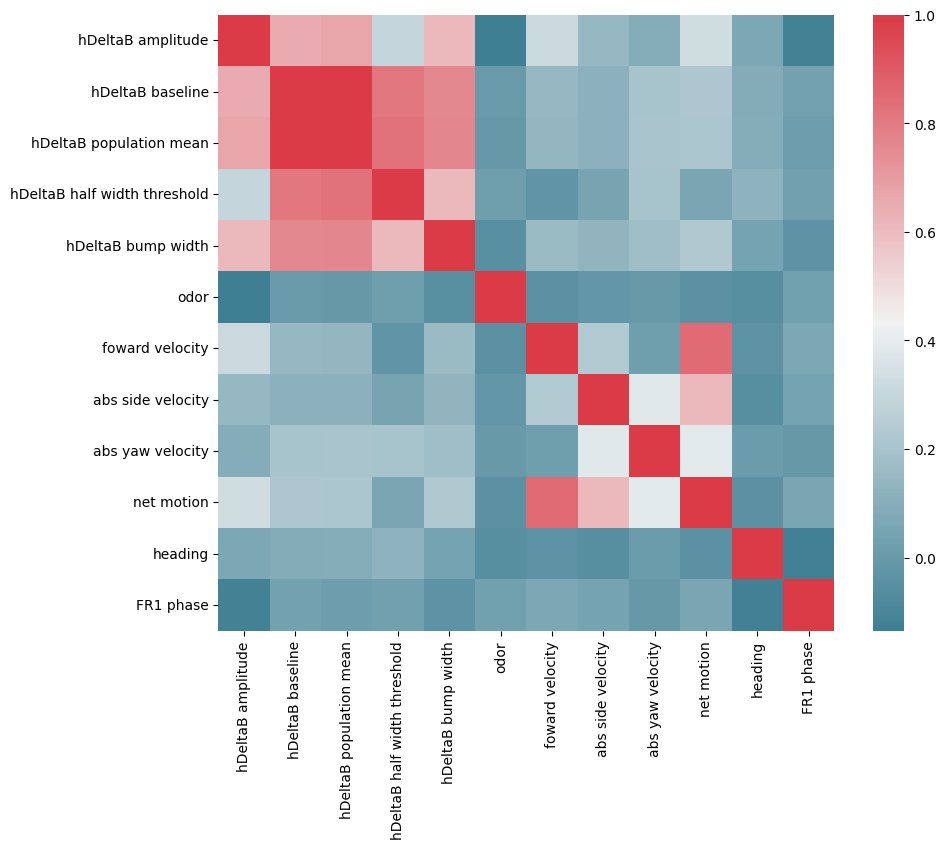

In [ ]:
# nonparametrix bump parameter extraction
from scipy.stats import iqr
bump_height = iqr(df_fl_tr, axis=1)
threshold = np.percentile(df_fl_tr, 50, axis = 1)
mean_hDeltaB = np.mean(df_fl_tr, axis=1)
half_height = 0.5*np.max(df_fl_tr,axis =1)
width = np.zeros(np.shape(df_fl_tr)[0])
for i in range(len(width)):
    width[i] = np.sum(df_fl_tr[i,:]>half_height[i])/np.shape(df_fl_tr)[1]
var = ['odor','fwV', 'abssideV', 'absyawV', 'net_motion','heading']
X = amp_sinfit
X = np.vstack((X,base_sinfit))  
X = np.vstack((X,mean_hDeltaB)) 
X = np.vstack((X,threshold)) 
X = np.vstack((X,width)) 
#X = np.vstack((X,odor_start_bi)) 
#X = np.vstack((X,odor_end_bi)) 
for i in range(len(var)):
    X = np.vstack((X,fl_df[var[i]]))
X = np.vstack((X,phase_sinfit))
#X = np.vstack((X,phase_sinfit)) 

df_plot = pd.DataFrame(data = X.T, columns = ['hDeltaB amplitude','hDeltaB baseline','hDeltaB population mean','hDeltaB half width threshold','hDeltaB bump width','odor','foward velocity', 'abs side velocity', 'abs yaw velocity', 'net motion','heading','FR1 phase'])

f, ax = plt.subplots(figsize=(10, 8))
corr = df_plot.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool_), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

<Axes: >

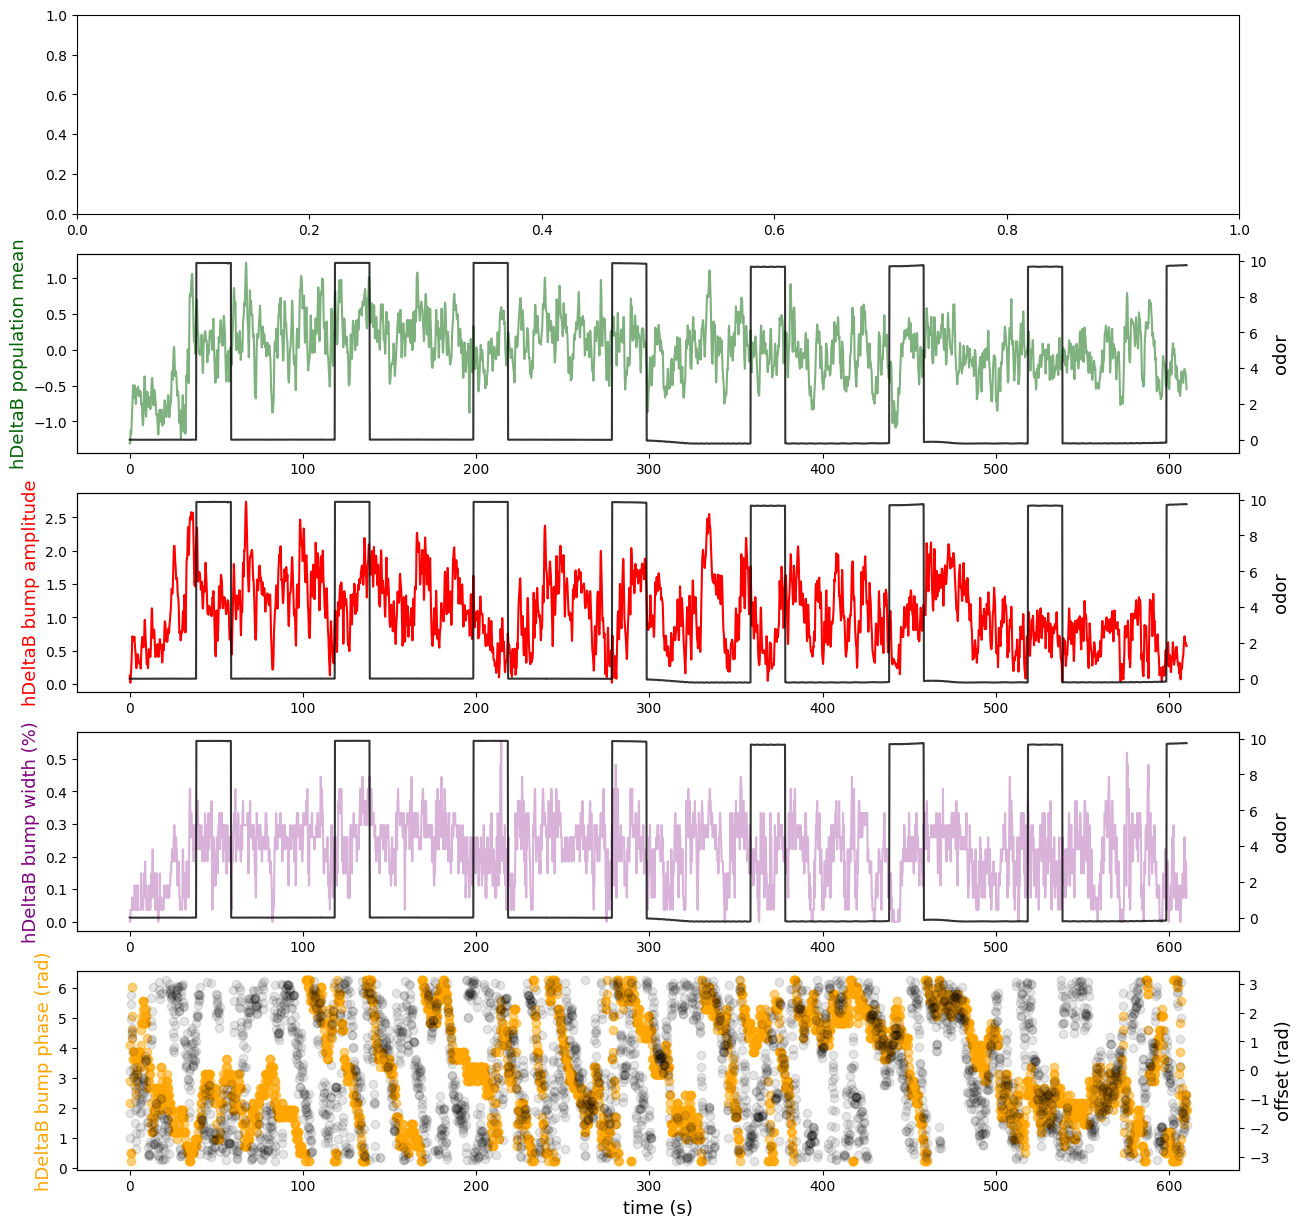

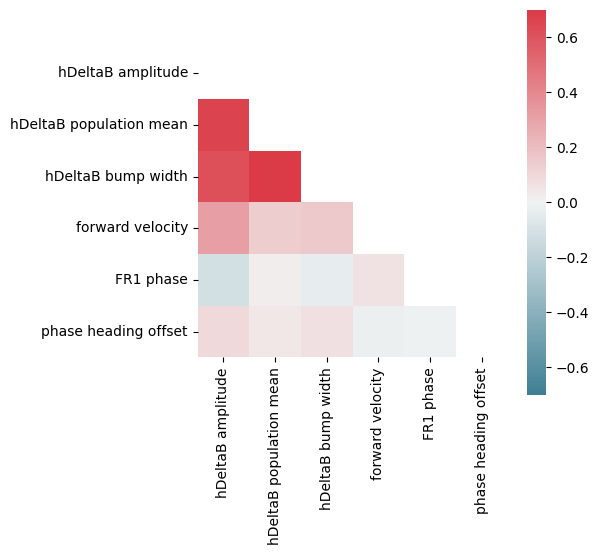

In [ ]:
fig_ex, ax = plt.subplots(5,1,figsize=[15,15])
ind1 = 0
ind2 = len(fl_df) 
#ax[0].plot(fl_df.time[ind1:ind2], fl_df.mean_CRE[ind1:ind2],color = 'orangered')
#ax[0].plot(fl_df.time[ind1:ind2], fl_df.MBON09R[ind1:ind2],color = 'red')
#ax3 = ax[0].twinx()
#ax3.plot(fl_df.time[ind1:ind2], fl_df.odor[ind1:ind2],color='black',alpha = 0.8)
#ax3.set_ylabel('odor', fontsize = 13, color = 'black')
#ax[0].set_ylabel('mean FR1 CRE', fontsize = 13, color = 'orangered')
ax[2].plot(fl_df.time[ind1:ind2], amp_sinfit[ind1:ind2],color = 'red')
#ax[1].plot(fl_df.time[ind1:ind2], base_sinfit[ind1:ind2],color = 'green')
ax[2].set_ylabel('hDeltaB bump amplitude', fontsize = 13, color = 'red')
ax4 = ax[2].twinx()
ax4.plot(fl_df.time[ind1:ind2], fl_df.odor[ind1:ind2],color='black',alpha = 0.8)
ax4.set_ylabel('odor', fontsize = 13, color = 'black')
ax[1].plot(fl_df.time[ind1:ind2],mean_hDeltaB[ind1:ind2], color = 'darkgreen',alpha = 0.5)
ax[1].set_ylabel('hDeltaB population mean', fontsize = 13, color = 'darkgreen')
ax2 = ax[1].twinx()
ax2.plot(fl_df.time[ind1:ind2], fl_df.odor[ind1:ind2],color='black',alpha = 0.8)
ax2.set_ylabel('odor', fontsize = 13, color = 'black')
ax[3].plot(fl_df.time[ind1:ind2], width[ind1:ind2],color ='purple',alpha = 0.3)
ax[3].set_ylabel('hDeltaB bump width (%)', fontsize = 13, color = 'purple')
ax6 = ax[3].twinx()
ax6.plot(fl_df.time[ind1:ind2], fl_df.odor[ind1:ind2],color='black',alpha = 0.8)
ax6.set_ylabel('odor', fontsize = 13, color = 'black')
#ax[2].scatter(fl_df.time[ind1:ind2],2*np.pi-phase_sinfit[ind1:ind2], color = 'orange',alpha = 0.3)
#ax[2].scatter(fl_df.time[ind1:ind2], fl_df.heading[ind1:ind2],color ='blue',alpha = 0.3)
ax[4].scatter(fl_df.time[ind1:ind2], 2*np.pi-phase_sinfit[ind1:ind2],color ='orange',alpha = 0.5)
ax[4].set_ylabel('hDeltaB bump phase (rad)', fontsize = 13, color = 'orange')
ax[4].set_xlabel('time (s)', fontsize = 13, color = 'black')
ax5 = ax[4].twinx()
ax5.scatter(fl_df.time[ind1:ind2], phase_dif[ind1:ind2],color ='black',alpha = 0.1)
#ax5.scatter(fl_df.time[ind1:ind2], smooth(phase_dif[ind1:ind2],10),color ='black',alpha = 0.3)
#ax[3].scatter(fl_df.time[ind1:ind2], heading_intp[ind1:ind2],color ='orange',alpha = 0.3)
#ax[3].scatter(jumpbar_pd.time[:-600], 2*np.pi-jumpbar_pd.panel_heading[600:],color ='orange',alpha = 0.1)
#for i in range(len(jump_idx[0])):
   # ax[3].axvline(jumpbar_pd.time[jump_idx[0][i]],color ='red')
#ax[3].scatter(fl_df.time[ind1:ind2], 2*np.pi-heading_interp,color ='green',alpha = 0.3)
#ax[3].axvline(x = fl_df.time[int(np.ceil(bar_jump_scaled))],color = 'black')
#ax[3].axvline(x = fl_df.time[int(np.floor(bar_jump_scaled))],color = 'black')
ax5.set_ylabel('offset (rad)', fontsize = 13, color = 'black')


X= amp_sinfit
#X = np.vstack((X,np.nan_to_num(rho_pd[1:],0)))
#X = np.vstack((X,odor_start_bi))  
#X = np.vstack((X,odor_end_bi))  
#X = np.vstack((X,switch_bi)) 
#X = np.vstack((X,amp_sinfit)) 
#X = np.vstack((X,base_sinfit))  
X = np.vstack((X,mean_hDeltaB)) 
#X = np.vstack((X,threshold)) 
X = np.vstack((X,width))
#X = np.vstack((X,width_nor)) 
X = np.vstack((X,fl_df.fwV))
X = np.vstack((X,phase_sinfit))
X = np.vstack((X,phase_dif))
#df_plot = pd.DataFrame(data = X.T, columns = ['MBON09','straightness','time_since_change','distance_since_change','motion_since_change','odor_start','odor_end','start_1','start_2','start_3','start_4','start_5','start_6','start_7','start_8','end_1','end_2','end_3','end_4','end_5','end_6','end_7','foward velocity', 'abs yaw velocity', 'net motion','heading'])
df_plot = pd.DataFrame(data = X.T, columns = ['hDeltaB amplitude','hDeltaB population mean','hDeltaB bump width','forward velocity','FR1 phase','phase heading offset'])

f, ax = plt.subplots(figsize=(5, 5))
corr = df_plot.corr()
up_tri = np.triu(corr)

sns.heatmap(corr,mask=up_tri, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-0.7, vmax=0.7,
            square=True, ax=ax)